In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from os import listdir
from skimage import morphology
from skimage import transform

In [ ]:
location = {}
location["image"] = "../data/example_image/"
location["segmentation"] = "../data/example_segmentation/"

image = "ISIC_0001769"
seg_suffix = "_segmentation.png"

im = mpimg.imread(location["image"]+image+".jpg")
segment_one = mpimg.imread(location["segmentation"]+image+seg_suffix)


In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(im)
ax[1].imshow(segment_one, cmap = "gray")

In [ ]:
#Finding the center
borders = np.where(segment_one!=0)
up, down = min(borders[0]),max(borders[0])
left, right = min(borders[1]),max(borders[1])
center = ((up+down)//2, (left+right)//2)
trial = (np.mean(borders[0]), np.mean(borders[1]))
print(up,down,left,right)
print(center)
print(trial)

In [ ]:
#plotting the center over the segmentation
plt.imshow(segment_one, cmap = "gray")
plt.scatter(x=center[1], y =center[0])
plt.scatter(x=trial[1],y=trial[0], color="pink")

In [ ]:
new_img = segment_one[up:down, left:right]
nborder = np.where(segment_one[up:down, left:right] != 0)
print(nborder)
u, d, l, r = min(nborder[0]), max(nborder[0]), min(nborder[1]), max(nborder[1])
print("up, down, left, right:",u,d,l,r)
print("half down, half right:",d//2,r//2)
print("mean of border:", np.mean(nborder[1]),np.mean(nborder[0]))
plt.imshow(new_img, cmap="gray")
plt.scatter(x=(r)//2, y= (d)//2, color = "orange")
plt.scatter(x=np.mean(nborder[1]),y=np.mean(nborder[0]), color="magenta")

In [ ]:
struct_el = morphology.disk(10)
mask_eroded = morphology.binary_erosion(new_img, struct_el)
image_perimeter = new_img-mask_eroded

non_flipped, flipped = image_perimeter[:,:r//2+1], np.flip(image_perimeter[:,r//2:],1)
flipped_im = np.flip(image_perimeter,1)
overlap = non_flipped.copy()
overlap[flipped==1] = 1

flipped_nonzero = np.count_nonzero(flipped_im)
overlap_nonzero = np.count_nonzero(non_flipped)
print("flipped nonzero:",flipped_nonzero)
print("nonflipped nonzero:",overlap_nonzero)
print("flipped - nonflipped", flipped_nonzero - overlap_nonzero)

fig, ax = plt.subplots(1,3)
ax[0].imshow(non_flipped, cmap="gray")
ax[1].imshow(flipped, cmap="gray")
ax[2].imshow(overlap, cmap="gray")

In [ ]:
non_flipped.shape[1] == overlap.shape[1]

In [ ]:
def border_overlap(image):
    """
    Marks the border of a lesion, and divides this into left and rigt sub-images through the middle of the image.
    the quotient of non-zero pixels between the two halves of the image overlayed and only the left side is calculated
    and saved in a list. The image is then rotated 10 degrees, and the process is repeated, untill a rotation of 180
    degrees have been made. Returns the minimum quotient stored in the list, and the rotation of the image required
    to make that minimum, stored in degrees.
    """
    struct_el = morphology.disk(10)
    mask_eroded = morphology.binary_erosion(image, struct_el)
    image_perimeter = image-mask_eroded #Making the border of the image only
    right = image_perimeter.shape[1] #The width of the image, used to find the middle
    nonzero_list = []
    for angle in range(0,181,10):
        rotated_image = transform.rotate(image_perimeter, angle) #Rotating the image by a multiple of 10 degrees
        non_flipped, flipped = rotated_image[:,:int(right/2)], np.flip(rotated_image[:,int(right/2):],1) #dividing the image into left and right halves
        dimension_diff = non_flipped.shape[1] - flipped.shape[1] #Finding possible differences in dimensions of the halves
        non_flipped = rotated_image[:,:int(right/2)-dimension_diff] #Done to avoid dimensional comparison errors
        overlap = non_flipped.copy() #Copying one half to ensure that we don't make shallow copies of the original image
        overlap[flipped==1] = 1 #The actual overlay
        flipped_nonzero = np.count_nonzero(flipped_im) #Calculates non-zero pixels of the right image
        overlap_nonzero = np.count_nonzero(overlap) #Calculates non-zero pixels of the left image
        nonzero_list.append(abs(overlap_nonzero/flipped_nonzero*100)) #Appends 'non-zero overlap / non-zero' left to a list
    return(min(nonzero_list),nonzero_list.index(min(nonzero_list))) #Returns the minimum of the nonzero list after the image has been rotated 180 degrees


In [ ]:
def make_border_symmetry_csv(filepath):
    """
    Function that takes image names from a filepath and returns the 'image_id' and contents of the 'border-overlap'
    function to a .csv file called 'border_symmetry' in the data/processed folder.
    """
    unfiltered_images = listdir(filepath) #Get the list of names of everything in the specified directory
    filter_img = [i.strip(".jpg") for i in unfiltered_images if ".jpg" in i] #Make list of only image names
    most_overlap_list = [["image_id", "border_diff_percent", "rotation_amount_deg"]] #list with headers for the csv file
    for i in filter_img[]: #Loop through list
        image = plt.imread(location["segmentation"]+i+seg_suffix) #Load corresponding image segmentation of the image name
        borders = np.where(image!=0) #Find non-zero elements of the image
        up, down = min(borders[0]),max(borders[0]) #min and max height of image
        left, right = min(borders[1]),max(borders[1]) #Min and max width of image
        segment_image = image[up:down,left:right] #'Zoomed-in' image, discarding non-lesion parts of the image
        j, k = border_overlap(segment_image) # Call to func border_overlap
        most_overlap_list.append([i,j,k*10]) #Append image_id, border-quotient and degree-rotation to the list
    np.savetxt("../data/processed/border_symmetry.csv",
        most_overlap_list, delimiter=",", fmt = "% s") #Turn list into .csv file in the data/processed folder
    print('Make_broder_symmetry_csv done') #Reassuring message that it went succesfully :)

make_border_symmetry_csv("../data/example_image")

In [ ]:
np.savetxt("../data/processed/border_symmetry.csv",
          most_overlap_list, delimiter=",", fmt = "% s")

3023
[29200.0, 8795.0, 8060.0, 7366.0, 6729.0, 5452.0, 4239.0, 3413.0, 1031.0, 118.12962962962963, 884.5, 1453.0, 2480.0, 4605.0, 5174.0, 6376.0, 7020.0, 7738.0, 19211.0]



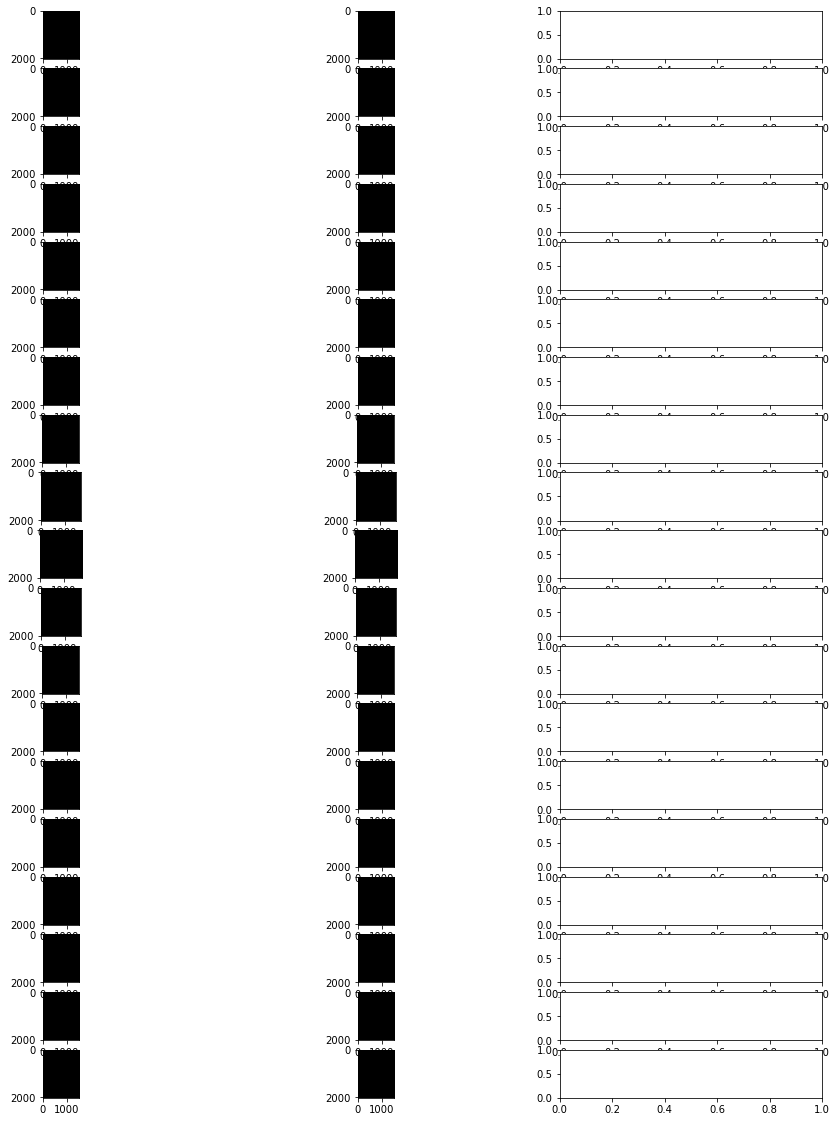

In [52]:
fig, ax = plt.subplots(19,3, figsize=(16,20))
iim = mpimg.imread(location["image"]+"ISIC_0007156"+".jpg")
nborder = np.where(iim != 0)

up,down,left,right = min(nborder[0]), max(nborder[0]), min(nborder[1]), max(nborder[1])
print(right)
zoom_iim = iim[up:down,left:right]
nonzero_list = []
symmetry_list = []
for angle in range(0,181,10):
    rotated_image = transform.rotate(iim, angle)
    border = np.where(rotated_image!=0)
    right = max(border[1])
    non_flipped, flipped = rotated_image[:,:int(right/2)], np.flip(rotated_image[:,int(right/2):],1)
    dimension_diff = non_flipped.shape[1] - flipped.shape[1]
    non_flipped = rotated_image[:,:int(right/2)-dimension_diff] #done to avoid dimensional comparison errors
    overlap = non_flipped.copy()
    overlap[flipped==1] = 1
    
    non_flipped_int = non_flipped.astype(int)
    flipped_int = flipped.astype(int)
    
    intersection = np.bitwise_or(non_flipped_int, flipped_int)
    union = np.bitwise_and(non_flipped_int, flipped_int)
    res = np.count_nonzero(intersection) / (np.count_nonzero(union)+1)
    symmetry_list.append(res)

    ax[angle//10,0].imshow(intersection)
    ax[angle//10,1].imshow(union)
    #ax[angle//10,2].imshow(res)
    
print(symmetry_list)
print()    

#         height, width = non_flipped.shape
#         area = height*width
# flipped_nonzero = np.count_nonzero(flipped_im)
# overlap_nonzero = np.count_nonzero(overlap)
# #     nonflipped_list.append(flipped_nonzero//flipped_nonzero*100)
# nonzero_list.append(abs(overlap_nonzero/flipped_nonzero*100))
#     ax[angle//10,0].imshow(non_flipped)
#     ax[angle//10,1].imshow(flipped)
#     ax[angle//10,2].imshow(overlap)

In [ ]:
print("Dimensions of Image 1: {} \nDimensions of Segmentation 1: {}".format(im.ndim, segment_one.ndim))
print()
print("Shape of Image 1: {} \nShape of Segmentation 1: {}".format(im.shape, segment_one.shape))

In [ ]:
#PIL Imaging
img1 = Image.open(location["image"]+image+".jpg")
img2 = Image.open(location["segmentation"]+image+seg_suffix)

img2.paste(img1, (0,0), mask = img2)

plt.imshow(img2, cmap = "gray")
print(img2.size)

In [ ]:
img1 = im.copy()
img1[segment_one==0]=0
plt.imshow(img1)
print(img1[img1!=0].shape)
print(img1.shape[0]*img1.shape[1])
print(np.sum(img1))
print(np.sum(segment_one))

In [ ]:
fig, ax = plt.subplots(15,10, figsize = (30,20))
ax0 = 0
ax1 = 0
for i in filter_img:
    temp_img = plt.imread(location["image"]+i+".jpg")
    ax[ax0,ax1].imshow(temp_img)
    ax1 += 1
    if ax1 >9:
        ax1=0
        ax0+= 1
        

In [ ]:
fig, ax = plt.subplots(15,10, figsize = (80,40))
ax0 = 0
ax1 = 0
for i in filter_img:
    temp_img = plt.imread(location["segmentation"]+i+seg_suffix)
    border = np.where(temp_img != 0)
    u,d,l,r = min(border[0]), max(border[0]), min(border[1]), max(border[1])
    zoom_border = np.where(temp_img[u:d,l:r] != 0)
    down, right = max(zoom_border[1]), max(zoom_border[0])
    ax[ax0,ax1].imshow(temp_img[u:d,l:r], cmap = "gray")
    ax[ax0,ax1].scatter(x=np.mean(zoom_border[1]),y=np.mean(zoom_border[0]),color="darkred", alpha = 0.9, s = 100)
    ax[ax0,ax1].scatter(x=down//2,y=right//2, color = "blue", s = 100)
    ax1 += 1
    if ax1 >9:
        ax1=0
        ax0+= 1
